In [1]:
import numpy as np
from nodes.nodes import FoldiakNode, InputNode
from nodes.net import FoldiakShapedNet
from nodes.layer import ShapedLayer

import random
import matplotlib.pyplot as plt

#random.seed(7)

inputlayer = ShapedLayer((8,8))
foldiaklayer = ShapedLayer(16)

foldiaklayer.fillnodes(FoldiakNode)
inputlayer.fillnodes(InputNode)

network = FoldiakShapedNet()
network.append(inputlayer)
network.append(foldiaklayer)
network.connect_foldiak(inputlayer, foldiaklayer)

network.setparam("intmethod","LSODA")
network.setparam("p",0.125)
network.setparam("l",10)
network.setparam("tmax",100)

In [2]:
network.setup()
network.setup()

In [3]:
foldiaklayer.nodes[0].p

0.125

In [4]:
samples = np.loadtxt("../data/lines_unbalanced.csv")
keys = np.loadtxt("../data/keys_unbalanced.csv")

In [5]:
perm = np.random.permutation(len(keys))

samples = samples[perm]
keys = keys[perm]

In [6]:
#Steady state thres:
network.setparam("a",0.0)
network.setparam("b",0.0)
network.setparam("y",0.5)
network.setparam("d",0.0)
network.setparam("cr",0.0)

for i in range(200):
    for i in inputlayer.nodes:
        i.setvalstored(random.uniform(0,1))
    network.update()

In [7]:
network.setparam("a",0.1)
network.setparam("b",0.02)
network.setparam("y",0.02)
network.setparam("d",0.015)
#network.setparam("cr",0.0001)
network.setparam("cr", 0.0)

In [8]:
possibletypes = []
for i in range(8):
    sample = np.zeros((8,8))
    sample[i,:] = 1
    possibletypes.append(sample)
for i in range(8):
    sample = np.zeros((8,8))
    sample[:,i] = 1
    possibletypes.append(sample)

In [9]:
key_errors = []
mem_errors = []
inh_means  = []
inh_stds   = []
inh_mins   = []
inh_maxes  = []

inh_biases = []
for_biases = []
threses    = []
ps         = []
cs         = []

startnum = 0
for i in range(1):
    for startnum in range(50):

        permutation = [0,0,0,0,0,0,0,0,
                       0,0,0,0,0,0,0,0]
        outimages = []

        for j in range(16):
            lowestmin = 64
            outimage = np.zeros((8,8))
            goestonum = 0
            tnum = 0
            for i in possibletypes:
                mem = np.reshape(network.cgroups[0].getbiases()[:,j],(8,8))
                mem = mem/mem.max()
                er = np.sum(np.abs(mem - i))
                #print(er)
                if (er < lowestmin):
                    lowestmin = er
                    outimage = np.abs(mem-i)
                    goestonum = tnum
                tnum += 1
            outimages.append(outimage)
            permutation[goestonum] = j
        ersum = 0
        for i in outimages:
            ersum += np.sum(i)
        mem_errors.append(ersum/(8*8*16))



        output_keys = np.zeros((1000,16))

        idx = np.empty_like(permutation)
        idx[permutation] = np.arange(len(permutation))

        test_keys_this = keys[startnum*1000:startnum*1000+1000, idx]
        test_samples_this = samples[startnum*1000:startnum*1000+1000]
        for i in range(1000):
            inputlayer.setvals(test_samples_this[i,:])
            network.update()
            output_keys[i,:] = foldiaklayer.returnvals()
            #if (i%1000)==999:
                #print(str(i+1)+"/"+str(25000))

        key_errors.append(np.sum(np.abs(test_keys_this-output_keys))/np.sum(test_keys_this))

        inh_means.append(network.cgroups[1].getbiases().mean())
        inh_stds.append(network.cgroups[1].getbiases().std())
        inh_mins.append(network.cgroups[1].getbiases().min())
        inh_maxes.append(network.cgroups[1].getbiases().max())

        inh_biases.append(network.cgroups[1].getbiases())
        for_biases.append(network.cgroups[0].getbiases())

        threses.append(foldiaklayer.returnthres())
        ps.append([i.p for i in foldiaklayer.nodes])
        cs.append([i.cert for i in foldiaklayer.nodes])

        if (startnum==-1):
            fig=plt.figure()

            for node_num in range(len(foldiaklayer.nodes)):
                testbias = []
                connects = np.reshape(network.cgroups[0].npconnects, -1)
                for node in inputlayer.nodes:
                    for i in connects:
                        if (i.input is node) and (i.output is foldiaklayer.nodes[node_num]):
                            testbias.append(i.bias)
                fig.add_subplot(4,4,node_num+1)

                plt.imshow(np.array(testbias).reshape((8,8)))
            fig.tight_layout()
            #plt.savefig("2020_07_07_bias_figure.png")
            plt.show()

            plt.imshow(np.abs(test_this_keys-output_keys))
            plt.show()

        if ((startnum+1)%5)==0:
            print("Finished: " + str(startnum+1))

Finished: 5
Finished: 10
Finished: 15
Finished: 20
Finished: 25
Finished: 30
Finished: 35
Finished: 40
Finished: 45
Finished: 50


In [10]:
#np.savetxt("images/2020_07_22_modified_error.csv",np.array([[i*1000 for i in range(len(key_errors))], key_errors]))
#key_errors_orig = [i for i in key_errors]
#key_errors_orig = np.loadtxt("images/2020_07_22_modified_error.csv")[1]

In [11]:
from matplotlib import rc
rc('text', usetex=True)

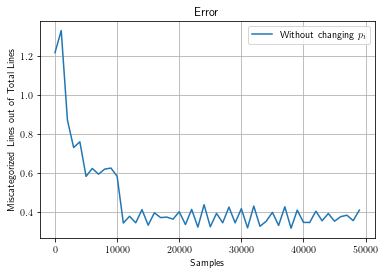

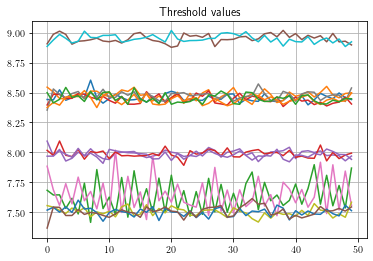

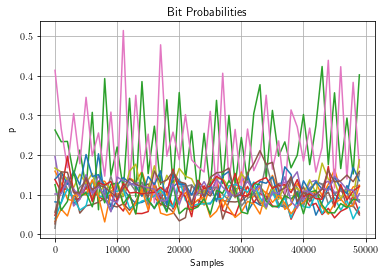

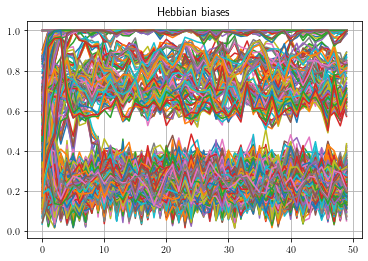

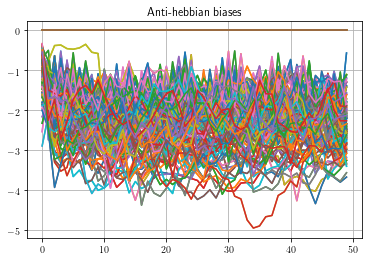

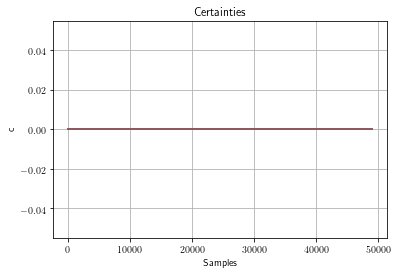

In [12]:
#plt.plot([i*1000 for i in range(len(key_errors))], key_errors_orig, label='With changing $p_i$')
plt.plot([i*1000 for i in range(len(key_errors))], key_errors, label='Without changing $p_i$')
#plt.plot([i*1000 for i in range(len(mem_errors))], mem_errors, label='Learned Memory Error')
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Miscategorized Lines out of Total Lines")
plt.grid()
plt.title("Error")
#plt.savefig("images/2020_07_22_LEB_comparison_error_graph.png", dpi=300)
plt.show()
plt.plot(threses)
plt.grid()
plt.title("Threshold values")
#plt.savefig("2020_07_11_LEB_wrong_thres_thresh_graph.png")
plt.show()
plt.plot([i*1000 for i in range(len(key_errors))], ps)
plt.xlabel("Samples")
plt.ylabel("p")
plt.grid()
plt.title("Bit Probabilities")
#plt.savefig("images/2020_07_16_unbalanced_p_graph.png")
plt.show()
for n in range(16):
    plt.plot([i[:,n] for i in for_biases])
plt.grid()
plt.title("Hebbian biases")
#plt.savefig("2020_07_11_LEB_wrong_thres_for_bias_graph.png")
plt.show()
for n in range(16):
    plt.plot([i[:,n] for i in inh_biases])
plt.grid()
plt.title("Anti-hebbian biases")
#plt.savefig("2020_07_11_LEB_wrong_thres_inh_bias_graph.png")
plt.show()

plt.plot([i*1000 for i in range(len(key_errors))], cs)
plt.xlabel("Samples")
plt.ylabel("c")
plt.grid()
plt.title("Certainties")
#plt.savefig("images/2020_07_16_unbalanced_p_graph.png")
plt.show()

In [12]:
sum(key_errors[-10:-1])/len(key_errors[-10:-1])

0.12609334515586734

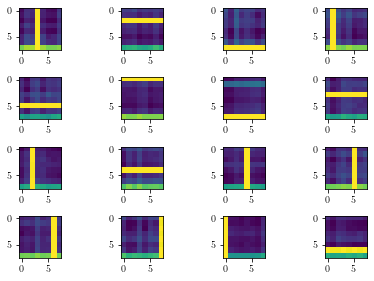

In [13]:
fig=plt.figure()

for node_num in range(len(foldiaklayer.nodes)):
    testbias = []
    connects = np.reshape(network.cgroups[0].npconnects, -1)
    for node in inputlayer.nodes:
        for i in connects:
            if (i.input is node) and (i.output is foldiaklayer.nodes[node_num]):
                testbias.append(i.bias)
    fig.add_subplot(4,4,node_num+1)
            
    im = plt.imshow(np.array(testbias).reshape((8,8)))
fig.tight_layout()
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)
#plt.savefig("images/2020_07_22_LEB_static_p_i_mems_no_colorbar.png")
plt.show()

In [12]:
permutation

[5, 8, 3, 2, 7, 6, 14, 4, 11, 15, 0, 10, 12, 9, 1, 13]

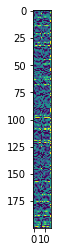

0.499
0.157875


In [10]:
plt.imshow((test_keys_this-output_keys)[:200,:])
plt.show()

print(np.sum(output_keys)/16000)
print(np.sum(test_keys_this)/16000)

In [11]:
changing_errors = np.loadtxt("images/2020_07_22_modified_error.csv")

In [16]:
changing_errors[1,-20:-1].mean()

0.027004055707999047

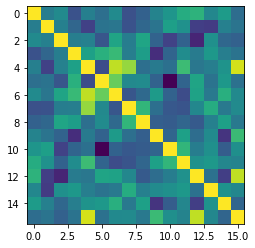

In [15]:
plt.imshow(network.cgroups[1].getbiases())
plt.show()

In [16]:
network.cgroups[1].getbiases().min()

-3.3243063673148563

In [17]:
y, t = network.diffeqs[0].getytplot()

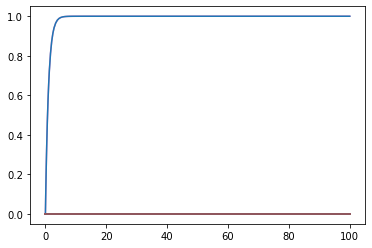

In [18]:
for i in range(16):
    plt.plot(t, y[i,:])
plt.show()

In [19]:
for i in foldiaklayer.nodes:
    print(i.p)

0.11567177621669401
0.12122618615085785
0.1275504534679271
0.12199842362169117
0.5496219645521124
0.13146087740209045
0.1279620067040506
0.12576570031936882
0.12835957944729304
0.1208396308348361
0.124200195690706
0.12400376286351501
0.12400395777079669
0.12099549811124496
0.12148961593280048
0.12070103536943855
